In [5]:
import numpy as np
import cupy as cp
import os
from bioio import BioImage
from skimage.io import imread
import tifffile
import timeit
from matplotlib import pyplot as plt

seed = 363
rng = np.random.default_rng(seed)

def show_mips(image, recon):
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(np.max(image.get(), axis=0), cmap='gray')
  plt.axis('off')
  plt.title('Original image MIP')
  plt.subplot(1, 2, 2)
  plt.imshow(np.max(recon, axis=0), cmap='gray')
  plt.axis('off')
  plt.title('Deconvolved image MIP')
  plt.show()

(1, 33830, 34684)


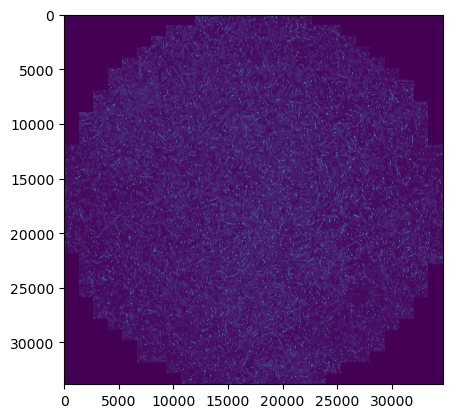

In [18]:
tg_image_path = r'D:\images\tnia-python-images\tg\2024_10_22_ts_decon'
tg_image_path = r'/home/bnorthan/images/tnia-python-images/tg/'
image_path = r'_small_data_\[AS-00304]\1x1_FOVs'
image_path = r'_small_data_/[AS-00304]/1x1_FOVs/'
image_name = r'Slide 1 - A02 - ROI 01_1x1_FOVs - DAPI.tif'

#image_path = r'_small_data_\[AS-00344]\3x3_FOVs'
#image_name = r'Slide 1 - Region 001 - ROI 02 - DAPI.tif'
#image_name = r'Slide 1 - Region 001 - ROI 02 - Cy 5.tif'
#image_name = r'Slide 1 - Region 001 - ROI 02 - FITC.tif'

image_path = r'_small_data_/[AS-00304]/3x3_FOVs/'
image_name = r'Slide 1 - A02 - ROI 02_3x3_FOVs - DAPI.tif'
image_name = r'Slide 1 - A02 - ROI 02_3x3_FOVs - FITC.tif'

image_path = r'_small_data_/[AS-00304]/roi_8bit/'
image_name = r'C2C12_A02-DAPI.tif'
image_name = r'C2C12_A02-FITC.tif'

#image_path = r'_small_data_/[AS-00304]/roi_16bit/'
#image_name = r'C2C12_A02-DAPI.tiff'
#image_name = r'C2C12_A02-FITC.tiff'

full_name = os.path.join(tg_image_path, image_path, image_name)

try:
  bioimg = BioImage(full_name)

  image = np.squeeze(bioimg.data)
except:
  image = imread(full_name)
  
# Add new z-axis if we have 2D data
if image.ndim == 2:
  image = np.expand_dims(image, axis=0)

print(image.shape)

plt.imshow(np.squeeze(image))

(0, 1)

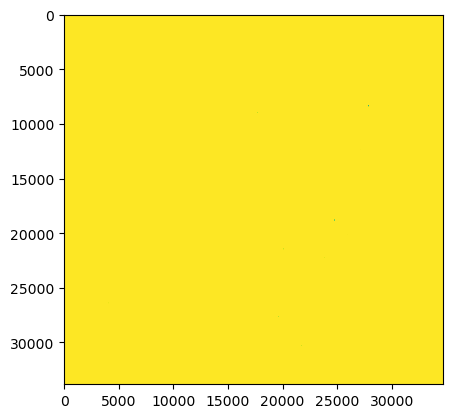

In [19]:
mask  = np.ones_like(image)
dtype = image.dtype

if dtype == np.uint8:
    mask[image==255] = 0


plt.imshow(np.squeeze(mask))

mask.min(), mask.max()

In [20]:
image = image.astype(np.float32)
mask = mask.astype(np.float32)

In [21]:
from tnia.deconvolution.gaussian_psf import gaussian_2d
sigma = 2.0
psf_temp = gaussian_2d(255,sigma)

# Add new z-axis if we have 2D data
if psf_temp.ndim == 2:
  psf_temp = np.expand_dims(psf_temp, axis=0)

# Pad to size of image
psf = np.zeros(image.shape)
psf[:psf_temp.shape[0], :psf_temp.shape[1], :psf_temp.shape[2]] = psf_temp
for axis, axis_size in enumerate(psf.shape):
  psf = np.roll(psf, int(axis_size / 2), axis=axis)
for axis, axis_size in enumerate(psf_temp.shape):
  psf = np.roll(psf, -int(axis_size / 2), axis=axis)
psf = np.fft.ifftshift(psf)
psf = psf / np.sum(psf)

: 

In [ ]:
# make image and psf cupy arrays
image = cp.array(image)
psf = cp.array(psf)
mask = cp.array(mask)

In [11]:
from rl_gradient_concensus import rlgc

recon = rlgc(image, psf, 100, False, mask)

Hu min: 16.323926997898326, max: 16.32393896399415
Iteration 001 completed in 1.454 s. KLDs = 0.4207 (image), 0.7378 (split 1), 0.7366 (split 2). 96.48 % of image updated. Update range: 0.01 to 11.50. Largest relative delta = 0.91305.
Hu min: 0.1356513647676563, max: 186.24758026623726
Iteration 002 completed in 1.370 s. KLDs = 0.0043 (image), 0.0737 (split 1), 0.0735 (split 2). 35.46 % of image updated. Update range: 0.30 to 1.42. Largest relative delta = 0.08120.
Hu min: 0.1124084619535167, max: 188.91953162542768
Iteration 003 completed in 1.371 s. KLDs = 0.0037 (image), 0.0727 (split 1), 0.0726 (split 2). 25.26 % of image updated. Update range: 0.44 to 1.42. Largest relative delta = 0.04552.
Hu min: 0.0989603682523599, max: 189.0148140966408
Iteration 004 completed in 1.372 s. KLDs = 0.0036 (image), 0.0724 (split 1), 0.0724 (split 2). 20.75 % of image updated. Update range: 0.50 to 1.31. Largest relative delta = 0.03576.
Hu min: 0.09196135024960948, max: 189.14488330129052
Iteratio

In [30]:
image.dtype

dtype('float32')

In [14]:
import napari
viewer=napari.Viewer()

image_ = np.squeeze(image.get()).astype(np.uint16)
recon_ = np.squeeze(recon.get()).astype(np.uint16)

min = np.min(image_)
max = np.max(image_)

viewer.add_image(image_, name='image', contrast_limits=(min, max))
viewer.add_image(recon_, name='recon', contrast_limits=(min, max))

<Image layer 'recon' at 0x78b289f68f70>

In [19]:
image_=image.get()
print(recon.min(), recon.max())

4.3520377989651283e-07 602.7196894682412


In [17]:
import napari
viewer=napari.Viewer()
viewer.add_image(image, name='image')

/home/bnorthan/mambaforge/envs/decon-dl-env2/lib/python3.9/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (33830, 34684) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/home/bnorthan/mambaforge/envs/decon-dl-env2/lib/python3.9/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (33830, 34684) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


<Image layer 'image' at 0x78b284d75700>

/home/bnorthan/mambaforge/envs/decon-dl-env2/lib/python3.9/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (33830, 34684) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
